In [1]:
# 模块1：加载与清洗 financial_news_events.csv

import pandas as pd

# 1. 加载数据
file_path = "financial_news_events.csv"  # 替换为你的路径
df = pd.read_csv(file_path)

print("✅ 原始数据加载完成")
print("数据维度:", df.shape)
print("数据列:", df.columns.tolist())
print(df.head(3))

# 2. 日期格式标准化
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# 3. 缺失值检查
print("\n📊 缺失值统计：")
print(df.isnull().sum())

# 4. 缺失值处理
# 填充文本缺失
df["Headline"] = df["Headline"].fillna("No Headline")
df["Sentiment"] = df["Sentiment"].fillna("Neutral")  # 默认缺失为中性
df["Index_Change_Percent"] = df["Index_Change_Percent"].fillna(0.0)
df["News_Url"]=df["News_Url"].fillna("N/A")

# 5. 统一列名风格（小写+下划线，方便后续处理）
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# 6. 数据基本统计
print("\n📈 数据描述：")
print(df.describe(include="all"))
print(df.isnull().sum())

# 7. 保存清洗后的数据
output_path = "financial_news_events_cleaned.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"\n✅ 数据清洗完成，已保存至 {output_path}")

✅ 原始数据加载完成
数据维度: (3024, 12)
数据列: ['Date', 'Headline', 'Source', 'Market_Event', 'Market_Index', 'Index_Change_Percent', 'Trading_Volume', 'Sentiment', 'Sector', 'Impact_Level', 'Related_Company', 'News_Url']
         Date                                           Headline  \
0  2025-05-21        Nikkei 225 index benefits from a weaker yen   
1  2025-05-18  Government subsidy program gives a lift to the...   
2  2025-06-25  New housing data release shows a slowdown in m...   

                    Source                Market_Event        Market_Index  \
0           Times of India       Commodity Price Shock                 DAX   
1          Financial Times        Central Bank Meeting  Shanghai Composite   
2  The Hindu Business Line  Consumer Confidence Report  Shanghai Composite   

   Index_Change_Percent  Trading_Volume Sentiment      Sector Impact_Level  \
0                  3.52          166.45       NaN  Technology         High   
1                 -3.39           57.61       NaN 

In [2]:
# 模块2：文本清洗 - 使用 spaCy (仅Headline)

import pandas as pd
import spacy

# 1. 加载 spaCy 英文模型
# 如果没下载过，执行一次: !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# 2. 加载模块1输出的数据
file_path = "financial_news_events_cleaned.csv"
df_cleaned = pd.read_csv(file_path)

print("✅ 已加载模块1清洗后的数据，样例：")
print(df_cleaned[["date", "headline", "sentiment"]].head(3))

# 3. 文本清洗函数
def clean_text(text):
    if pd.isna(text):
        return ""
    doc = nlp(text.lower())  # 小写化 + 解析
    tokens = [
        token.lemma_   # 词形还原
        for token in doc
        if not token.is_stop   # 去停用词
        and not token.is_punct  # 去标点
        and token.is_alpha      # 只保留字母
    ]
    return " ".join(tokens)

# 4. 基于 Headline 生成 cleaned_text
df_cleaned["cleaned_text"] = df_cleaned["headline"].fillna("").apply(clean_text)

# 5. 保存结果
output_path = "financial_news_events_preprocessed.csv"
df_cleaned.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\n✅ 模块2完成：已保存至 {output_path}")
print("示例清洗结果：")
print(df_cleaned[["headline", "cleaned_text"]].head(5))


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/wanjunxiao/myenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/wanjunxiao

✅ 已加载模块1清洗后的数据，样例：
         date                                           headline sentiment
0  2025-05-21        Nikkei 225 index benefits from a weaker yen   Neutral
1  2025-05-18  Government subsidy program gives a lift to the...   Neutral
2  2025-06-25  New housing data release shows a slowdown in m...   Neutral

✅ 模块2完成：已保存至 financial_news_events_preprocessed.csv
示例清洗结果：
                                            headline  \
0        Nikkei 225 index benefits from a weaker yen   
1  Government subsidy program gives a lift to the...   
2  New housing data release shows a slowdown in m...   
3  Massive stock buyback program announced by a c...   
4  Government spending bill is expected to stimul...   

                                        cleaned_text  
0                      nikkei index benefit weak yen  
1  government subsidy program give lift agricultu...  
2  new housing datum release show slowdown market...  
3  massive stock buyback program announce consume...  
4  gover

In [3]:
!pip -q install transformers torch scikit-learn

In [4]:
# =======================
# 模块3（稳健版）：SLM + LLM 情绪分析（不使用 pipeline，也不依赖 numpy）
# =======================
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 0) 环境设置：Apple 芯片优先用 MPS，算子不支持时自动回退 CPU
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
device = "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() \
         else ("cuda" if torch.cuda.is_available() else "cpu")
print("📌 device =", device)

# 1) 读取模块2输出
SRC = "financial_news_events_preprocessed.csv"
df = pd.read_csv(SRC)

# 文本输入：优先 headline，缺则退回 cleaned_text，再不行用占位
texts = []
for h, c in zip(df.get("headline", "").astype(str), df.get("cleaned_text", "").astype(str)):
    t = (h or "").strip()
    if not t or t.lower() == "no headline":
        t = (c or "").strip()
    if not t:
        t = "news"
    texts.append(t)

# -------- 2) SLM：DistilBERT (SST-2) 二分类 → 三分类 --------
SLM_ID = "distilbert-base-uncased-finetuned-sst-2-english"
tok_slm = AutoTokenizer.from_pretrained(SLM_ID)
net_slm = AutoModelForSequenceClassification.from_pretrained(SLM_ID).to(device).eval()

@torch.inference_mode()
def slm_predict_3class(batch_texts, neutral_band=(0.45, 0.55), bs=64, max_len=128):
    labels, confs = [], []
    for i in range(0, len(batch_texts), bs):
        enc = tok_slm(batch_texts[i:i+bs], truncation=True, padding=True,
                      max_length=max_len, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = net_slm(**enc).logits
        probs = torch.softmax(logits, dim=-1)   # [:,1] = P(positive)
        ppos = probs[:, 1].detach().cpu().tolist()  # 纯 Python list，不用 numpy
        for p in ppos:
            if neutral_band[0] <= p <= neutral_band[1]:
                labels.append("Neutral")
                confs.append(1 - 2*abs(p - 0.5))    # 简单定义：距0.5越近越不确定
            else:
                lab = "Positive" if p > neutral_band[1] else "Negative"
                conf = p if lab == "Positive" else (1 - p)
                labels.append(lab); confs.append(float(conf))
    return labels, confs

print("→ 运行 SLM 预测...")
df["predicted_sentiment_slm"], df["conf_slm"] = slm_predict_3class(texts, neutral_band=(0.45, 0.55))

# -------- 3) LLM：FinBERT 三分类（优先 safetensors，失败自动跳过） --------
def try_load_finbert(dev):
    candidates = [
        ("ProsusAI/finbert", {"use_safetensors": True}),           # safetensors，避免 torch.load 限制
        ("yiyanghkust/finbert-tone", {"use_safetensors": True}),   # 若仓库也提供 safetensors
    ]
    for mid, kwargs in candidates:
        try:
            tok = AutoTokenizer.from_pretrained(mid)
            net = AutoModelForSequenceClassification.from_pretrained(mid, **kwargs).to(dev).eval()
            print(f"✅ FinBERT loaded: {mid}")
            return tok, net
        except Exception as e:
            print(f"↪︎ Skip {mid}: {type(e).__name__}: {e}")
    return None, None

tok_llm, net_llm = try_load_finbert(device)

@torch.inference_mode()
def finbert_predict_3class(batch_texts, tok, net, bs=32, max_len=128):
    id2lbl = {0: "Negative", 1: "Neutral", 2: "Positive"}
    labels, confs = [], []
    for i in range(0, len(batch_texts), bs):
        enc = tok(batch_texts[i:i+bs], truncation=True, padding=True,
                  max_length=max_len, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = net(**enc).logits
        probs = torch.softmax(logits, dim=-1)
        conf, lab = probs.max(dim=-1)
        labels += [id2lbl[int(x)] for x in lab.detach().cpu().tolist()]
        confs  += [float(c) for c in conf.detach().cpu().tolist()]
    return labels, confs

if tok_llm is not None and net_llm is not None:
    print("→ 运行 LLM (FinBERT) 预测...")
    df["predicted_sentiment_llm"], df["conf_llm"] = finbert_predict_3class(texts, tok_llm, net_llm)
    # 简单集成：LLM 置信度≥0.55 用 LLM，否则用 SLM
    df["predicted_sentiment_ens"] = [
        ll if (cl is not None and cl >= 0.55) else sl
        for ll, cl, sl in zip(df["predicted_sentiment_llm"], df["conf_llm"], df["predicted_sentiment_slm"])
    ]
    df["conf_ens"] = [
        (cl if (cl is not None and cl >= 0.55) else cs)
        for cl, cs in zip(df["conf_llm"], df["conf_slm"])
    ]
else:
    print("⚠️ FinBERT 未加载成功，先以 SLM-only 继续")
    df["predicted_sentiment_llm"] = pd.NA
    df["conf_llm"] = pd.NA
    df["predicted_sentiment_ens"] = df["predicted_sentiment_slm"]
    df["conf_ens"] = df["conf_slm"]

# 4) 保存
OUT = "financial_news_events_with_sentiment.csv"
df.to_csv(OUT, index=False, encoding="utf-8-sig")
print(f"\n✅ 模块3完成：{OUT}")
print(df[["headline","predicted_sentiment_slm","predicted_sentiment_llm","predicted_sentiment_ens"]].head(10))

📌 device = cpu
→ 运行 SLM 预测...
✅ FinBERT loaded: ProsusAI/finbert
→ 运行 LLM (FinBERT) 预测...

✅ 模块3完成：financial_news_events_with_sentiment.csv
                                            headline predicted_sentiment_slm  \
0        Nikkei 225 index benefits from a weaker yen                 Neutral   
1  Government subsidy program gives a lift to the...                Positive   
2  New housing data release shows a slowdown in m...                Negative   
3  Massive stock buyback program announced by a c...                Negative   
4  Government spending bill is expected to stimul...                Positive   
5  Central bank maintains status quo on interest ...                Positive   
6  Tech Giant's New Product Launch Sparks Sector-...                Positive   
7  A massive data breach sends a tech company's s...                Negative   
8                                        No Headline                Positive   
9  Market sentiment turns positive on vaccine tri...        

In [5]:
# ===== Module 3b (optimized): TF-IDF + Logistic Regression baseline =====
import os, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump

PRE_FILE   = "financial_news_events_preprocessed.csv"       # 模块2输出
OUT_FILE   = "financial_news_events_with_sentiment.csv"     # 模块3输出（若不存在会新建）
MODEL_DIR  = "models"; os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "tfidf_lr.joblib")

# ---------- 1) 读取全量样本（用于最终逐行预测） ----------
df_all = pd.read_csv(PRE_FILE)
df_all["row_id"] = np.arange(len(df_all))  # 位置索引，写回时首选

# 统一/清洗标签（仅用于训练）
df_lab = df_all.copy()
df_lab["sentiment"] = df_lab["sentiment"].astype(str).str.title()
valid = {"Negative","Neutral","Positive"}
df_lab.loc[~df_lab["sentiment"].isin(valid), "sentiment"] = np.nan
df_lab = df_lab.dropna(subset=["sentiment"]).reset_index(drop=True)

if df_lab.empty:
    raise RuntimeError("No labeled samples in 'sentiment' — cannot train baseline.")

# 文本优先级：headline -> cleaned_text
def choose_text(df):
    x = df["headline"].fillna("").astype(str)
    mask = x.str.strip().eq("") | x.str.lower().eq("no headline")
    x[mask] = df.loc[mask, "cleaned_text"].fillna("").astype(str)
    return x

X_all = choose_text(df_all)      # 预测用（全量）
X_lab = choose_text(df_lab)      # 训练/评估用（有标签）
y_lab = df_lab["sentiment"].values

# ---------- 2) 时间序列切分（最后20%作测试） ----------
df_lab["date"] = pd.to_datetime(df_lab["date"], errors="coerce")
df_lab = df_lab.sort_values("date").reset_index(drop=True)
split = int(len(df_lab) * 0.8)
X_tr, X_te = X_lab.iloc[:split], X_lab.iloc[split:]
y_tr, y_te = y_lab[:split], y_lab[split:]

print(f"Samples — train={len(X_tr)}, test={len(X_te)}, all={len(X_all)}")

# ---------- 3) 管道：TF-IDF(1–2gram) + 逻辑回归 ----------
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2, max_df=0.95,
        sublinear_tf=True, strip_accents="unicode",
        lowercase=True, token_pattern=r"(?u)\b\w\w+\b",
        stop_words=None  # 可改为 'english' 试试
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",   # 自动按频次加权
        random_state=42,
        n_jobs=None,               # sklearn>=1.3 可用 n_jobs
        multi_class="auto",
        solver="lbfgs"
    ))
])

print("→ Training TF-IDF + Logistic Regression ...")
pipe.fit(X_tr, y_tr)

# ---------- 4) 测试集评估 ----------
y_pred = pipe.predict(X_te)
rep_df = pd.DataFrame(classification_report(y_te, y_pred, digits=4, output_dict=True)).T
cm = confusion_matrix(y_te, y_pred, labels=["Negative","Neutral","Positive"])
pd.DataFrame(cm,
    index=["ref_Negative","ref_Neutral","ref_Positive"],
    columns=["pred_Negative","pred_Neutral","pred_Positive"]
).to_csv("baseline_confusion.csv", index=True)
rep_df.to_csv("baseline_report.csv")
print("✅ saved: baseline_report.csv, baseline_confusion.csv")
print(rep_df[["precision","recall","f1-score"]].round(3).loc[["Negative","Neutral","Positive","macro avg","weighted avg"]])

# ---------- 5) 对全量样本预测并保存模型 ----------
pred_all  = pipe.predict(X_all)
proba_all = pipe.predict_proba(X_all)    # shape: [n, 3]
conf_all  = proba_all.max(axis=1)

dump(pipe, MODEL_PATH)
print(f"✅ saved model to: {MODEL_PATH}")

# ---------- 6) 写回主表（稳健合并策略） ----------
# 若 OUT_FILE 不存在，用 PRE_FILE 拷贝一份做骨架
if not os.path.exists(OUT_FILE):
    df_all.copy().to_csv(OUT_FILE, index=False, encoding="utf-8-sig")
    print(f"ℹ️ '{OUT_FILE}' not found. Created from '{PRE_FILE}'.")

df_out = pd.read_csv(OUT_FILE)

def write_back_by_position():
    if len(df_out) != len(df_all):
        return False
    df_out["predicted_sentiment_baseline"] = pred_all
    df_out["conf_baseline"] = conf_all
    df_out.to_csv(OUT_FILE, index=False, encoding="utf-8-sig")
    return True

def write_back_by_keys():
    # 尝试用 key 合并（date+headline+news_url 或 date+headline）
    keys_opts = [
        [c for c in ["date","headline","news_url"] if c in df_out.columns and c in df_all.columns],
        [c for c in ["date","headline"] if c in df_out.columns and c in df_all.columns],
    ]
    for keys in keys_opts:
        if len(keys) < 2:
            continue
        tmp = df_all[keys].copy()
        tmp["predicted_sentiment_baseline"] = pred_all
        tmp["conf_baseline"] = conf_all
        before = len(df_out)
        df_m = df_out.merge(tmp, on=keys, how="left", suffixes=("",""))
        if len(df_m) == before:
            df_m.to_csv(OUT_FILE, index=False, encoding="utf-8-sig")
            return True
    return False

ok = write_back_by_position() or write_back_by_keys()
if ok:
    print(f"✅ appended baseline predictions to '{OUT_FILE}'")
else:
    # 兜底：附加到单独文件，避免覆盖破坏
    alt_path = "financial_news_events_with_sentiment__with_baseline_tmp.csv"
    df_out2 = df_out.copy()
    df_out2["predicted_sentiment_baseline"] = np.nan
    df_out2["conf_baseline"] = np.nan
    print("⚠️ Could not align rows to write back safely. "
          f"Saving predictions separately to '{alt_path}'.")
    pd.DataFrame({
        "row_id": df_all["row_id"],
        "predicted_sentiment_baseline": pred_all,
        "conf_baseline": conf_all
    }).to_csv(alt_path, index=False, encoding="utf-8-sig")


Samples — train=2419, test=605, all=3024
→ Training TF-IDF + Logistic Regression ...
✅ saved: baseline_report.csv, baseline_confusion.csv
              precision  recall  f1-score
Negative          0.316   0.390     0.349
Neutral           0.398   0.351     0.373
Positive          0.268   0.237     0.251
macro avg         0.327   0.326     0.324
weighted avg      0.333   0.331     0.330


/Users/wanjunxiao/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ saved model to: models/tfidf_lr.joblib
✅ appended baseline predictions to 'financial_news_events_with_sentiment.csv'



=== SLM vs Reference ===
              precision    recall  f1-score   support

    Negative     0.3172    0.4517    0.3727       974
     Neutral     0.4107    0.0205    0.0390      1122
    Positive     0.2903    0.4946    0.3659       928

    accuracy                         0.3049      3024
   macro avg     0.3394    0.3223    0.2592      3024
weighted avg     0.3437    0.3049    0.2468      3024

Cohen's Kappa: -0.0148

=== LLM vs Reference ===
              precision    recall  f1-score   support

    Negative     0.3183    0.3337    0.3258       974
     Neutral     0.3682    0.5392    0.4376      1122
    Positive     0.3167    0.1228    0.1770       928

    accuracy                         0.3452      3024
   macro avg     0.3344    0.3319    0.3135      3024
weighted avg     0.3363    0.3452    0.3216      3024

Cohen's Kappa: -0.0025

=== Ensemble vs Reference ===
              precision    recall  f1-score   support

    Negative     0.3156    0.3480    0.3311       974


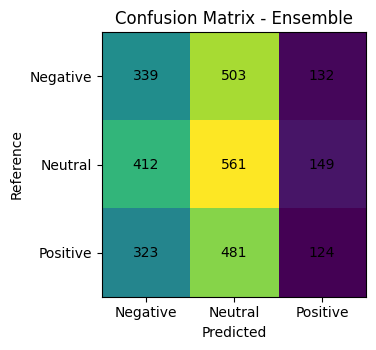

In [6]:
# ==== 模块3-Eval：新情绪 vs 参考 Sentiment（Macro-F1、Kappa、混淆矩阵、分歧样本） ====
import pandas as pd, numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt

SRC = "financial_news_events_with_sentiment.csv"
df  = pd.read_csv(SRC)

# 参考标签：来自数据集原始列（你的模块1已统一为小写 'sentiment'）
df["label_ref"] = df["sentiment"].astype(str).str.title().replace({"Nan": np.nan})
valid = {"Negative","Neutral","Positive"}
df.loc[~df["label_ref"].isin(valid), "label_ref"] = np.nan

# 选择预测列
pred_cols = []
if "predicted_sentiment_slm" in df.columns:  pred_cols.append(("SLM", "predicted_sentiment_slm"))
if "predicted_sentiment_llm" in df.columns:  pred_cols.append(("LLM", "predicted_sentiment_llm"))
if "predicted_sentiment_ens" in df.columns:  pred_cols.append(("Ensemble", "predicted_sentiment_ens"))
if "predicted_sentiment_baseline" in df.columns:  pred_cols.append(("Baseline", "predicted_sentiment_baseline"))


eval_df = df.dropna(subset=["label_ref"]).copy()
labels_order = ["Negative","Neutral","Positive"]

all_reports = []
for name, col in pred_cols:
    y_true = eval_df["label_ref"].tolist()
    y_pred = eval_df[col].astype(str).str.title().tolist()

    print(f"\n=== {name} vs Reference ===")
    print(classification_report(y_true, y_pred, labels=labels_order, digits=4))
    kappa = cohen_kappa_score(y_true, y_pred, labels=labels_order)
    print("Cohen's Kappa:", round(kappa, 4))

    # 混淆矩阵并保存
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    cm_df = pd.DataFrame(cm, index=[f"ref_{l}" for l in labels_order],
                            columns=[f"pred_{l}" for l in labels_order])
    cm_df.to_csv(f"eval_confusion_{name}.csv", index=True)

    # 报告DataFrame保存
    rep = classification_report(y_true, y_pred, labels=labels_order, output_dict=True)
    rep_df = pd.DataFrame(rep).T
    rep_df["model"] = name
    rep_df["kappa"] = kappa
    rep_df.to_csv(f"eval_report_{name}.csv")
    all_reports.append(rep_df)

# 汇总一个总表
if all_reports:
    pd.concat(all_reports).to_csv("eval_reports_all.csv")
    print("\n✅ 已保存：eval_confusion_*.csv, eval_report_*.csv, eval_reports_all.csv")

# 导出分歧样本（以 Ensemble 为主；若无，则用 SLM）
main_col = "predicted_sentiment_ens" if "predicted_sentiment_ens" in df.columns else "predicted_sentiment_slm"
disagree = eval_df[eval_df[main_col].str.title() != eval_df["label_ref"]].copy()
keep = ["date","headline","label_ref","predicted_sentiment_slm","predicted_sentiment_llm","predicted_sentiment_ens"]
keep = [c for c in keep if c in disagree.columns]
disagree[keep].head(50).to_csv("eval_disagreements_top50.csv", index=False)
print("✅ 分歧样本已保存：eval_disagreements_top50.csv")

# 画一个简单的混淆矩阵图（以 Ensemble 为例，若没有就用 SLM）
show_name = "Ensemble" if "predicted_sentiment_ens" in df.columns else "SLM"
y_true = eval_df["label_ref"].tolist()
y_pred = eval_df[ "predicted_sentiment_ens" if show_name=="Ensemble" else "predicted_sentiment_slm" ].astype(str).str.title()
cm = confusion_matrix(y_true, y_pred, labels=labels_order)

plt.figure(figsize=(4.5,3.6))
plt.imshow(cm)
plt.xticks(range(3), labels_order); plt.yticks(range(3), labels_order)
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center")
plt.title(f"Confusion Matrix - {show_name}")
plt.xlabel("Predicted"); plt.ylabel("Reference")
plt.tight_layout(); plt.show()

✅ Loaded columns: ['date', 'headline', 'source', 'market_event', 'market_index', 'index_change_percent', 'trading_volume', 'sentiment', 'sector', 'impact_level', 'related_company', 'news_url', 'cleaned_text', 'predicted_sentiment_slm', 'conf_slm', 'predicted_sentiment_llm', 'conf_llm', 'predicted_sentiment_ens', 'conf_ens', 'predicted_sentiment_baseline', 'conf_baseline']
✅ Saved: sentiment_daily_infile.csv  (rows=2030)
✅ Saved: correlation_summary.csv
✅ Saved: trend_summary.csv
📌 Will plot for indices: ['Shanghai Composite', 'S&P 500', 'Dow Jones', 'Hang Seng', 'TSX', 'Russell 2000']


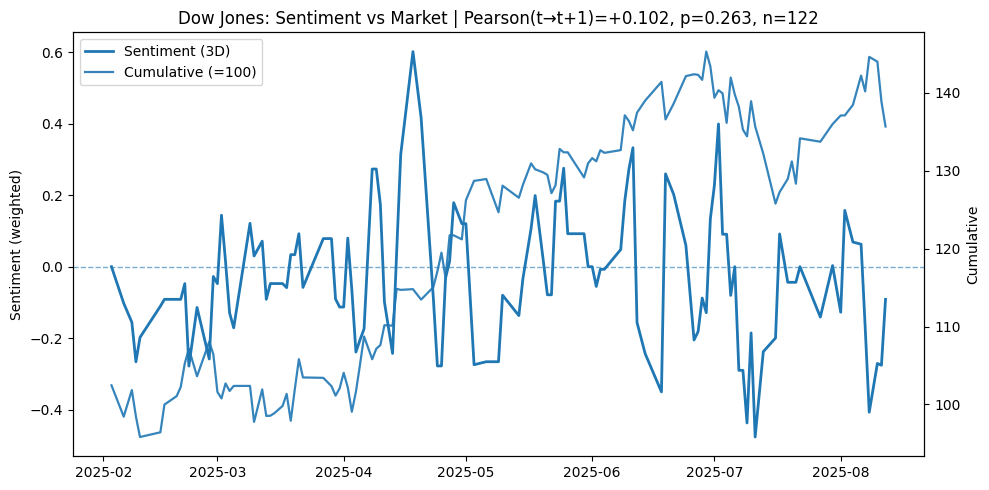

  → saved: figs/sent_vs_market_Dow_Jones.png


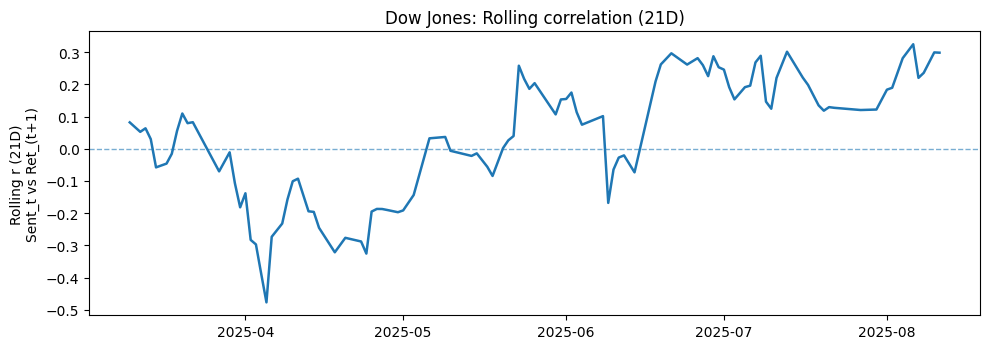

  → saved: figs/rolling_corr_Dow_Jones.png


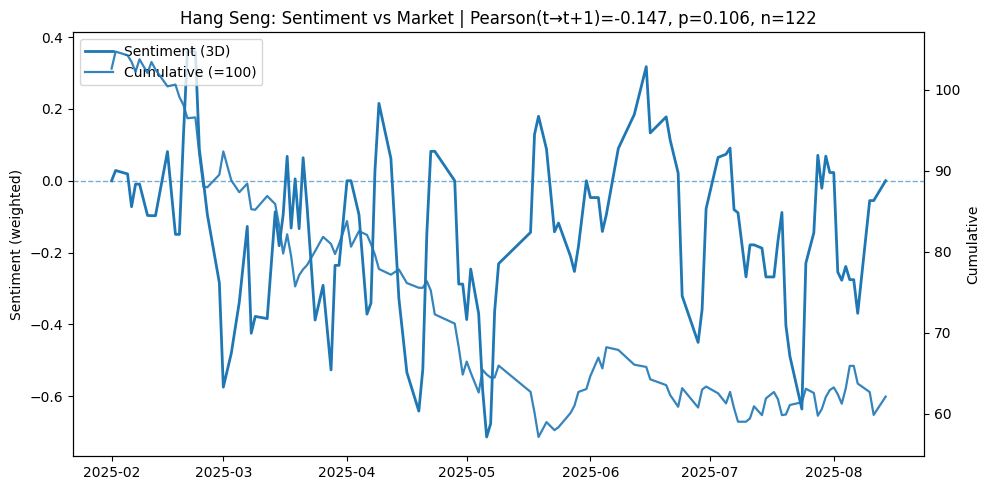

  → saved: figs/sent_vs_market_Hang_Seng.png


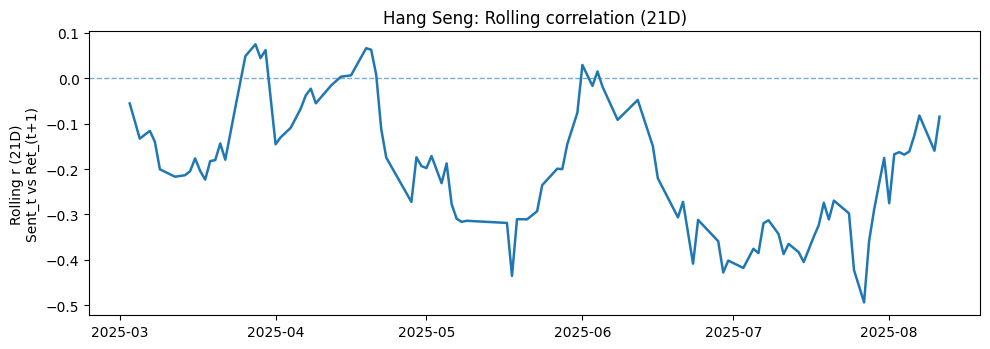

  → saved: figs/rolling_corr_Hang_Seng.png


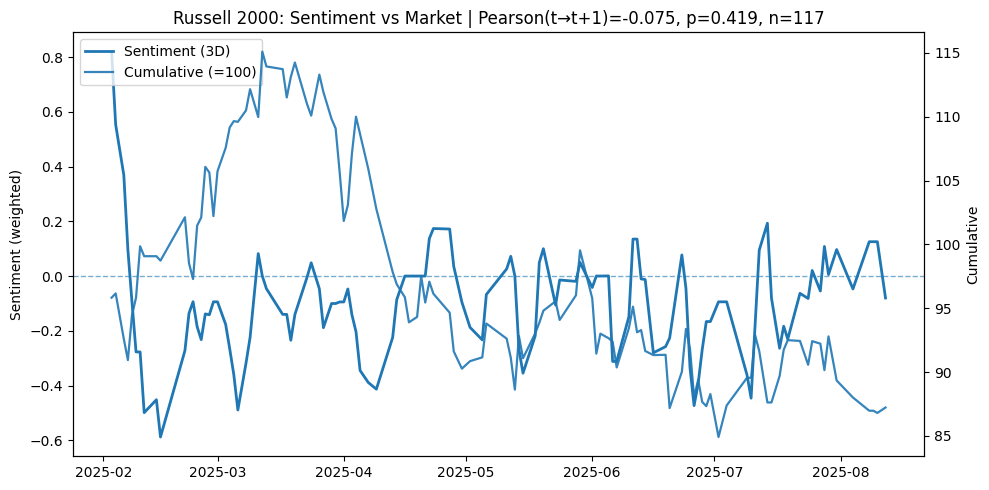

  → saved: figs/sent_vs_market_Russell_2000.png


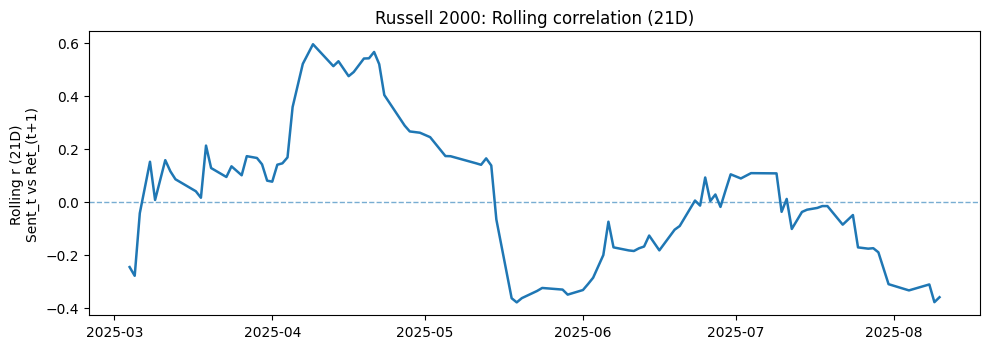

  → saved: figs/rolling_corr_Russell_2000.png


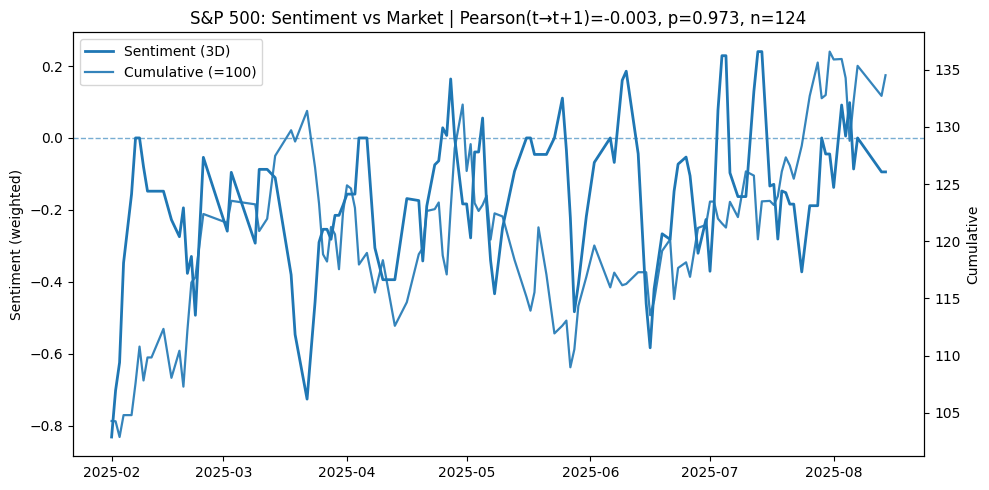

  → saved: figs/sent_vs_market_S_P_500.png


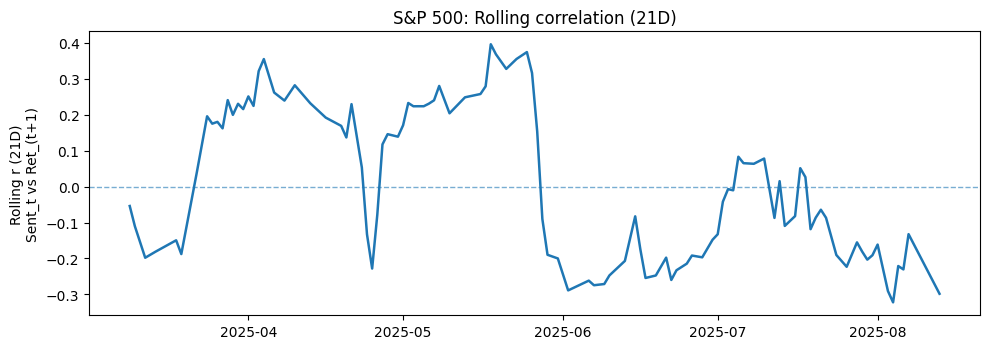

  → saved: figs/rolling_corr_S_P_500.png


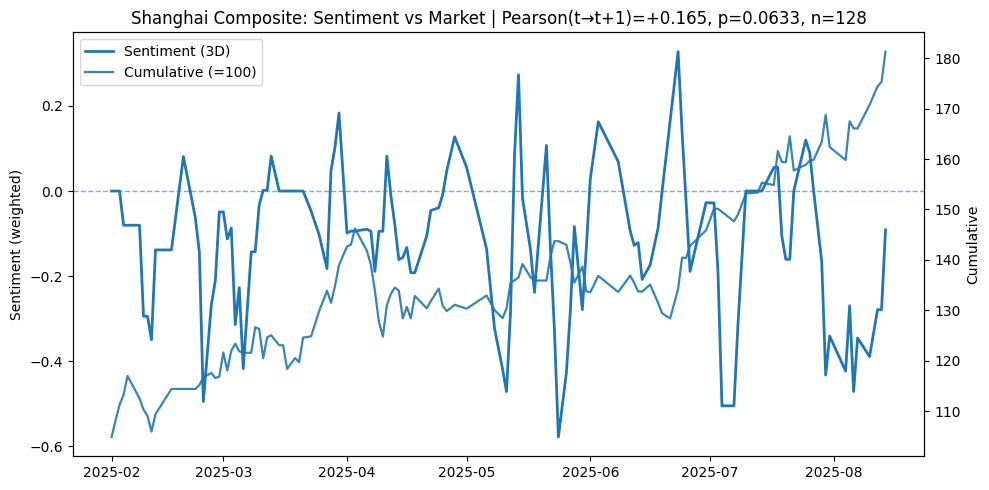

  → saved: figs/sent_vs_market_Shanghai_Composite.png


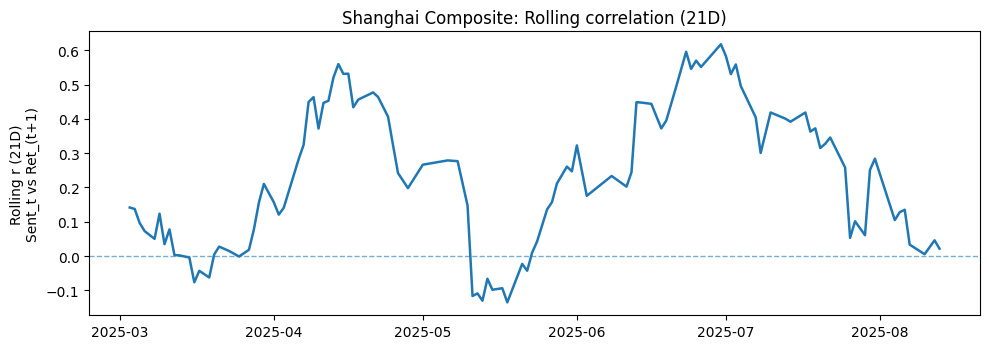

  → saved: figs/rolling_corr_Shanghai_Composite.png


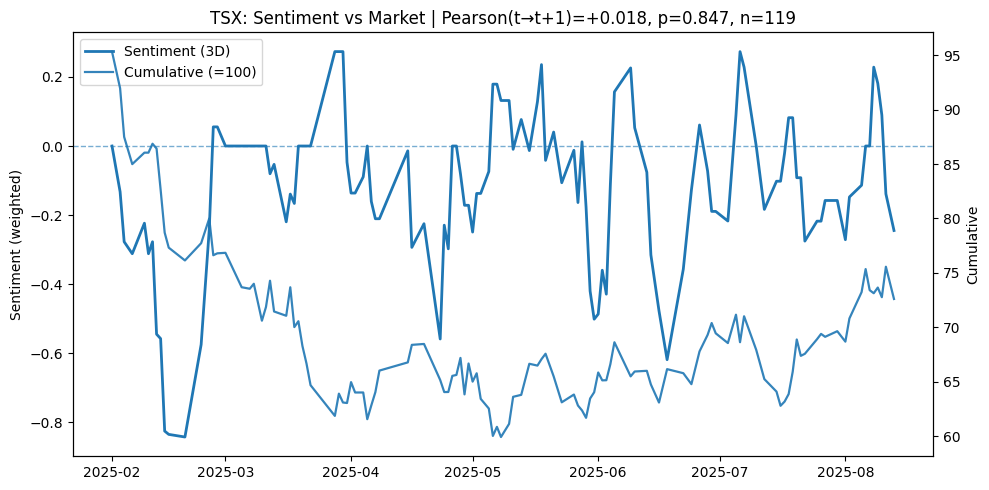

  → saved: figs/sent_vs_market_TSX.png


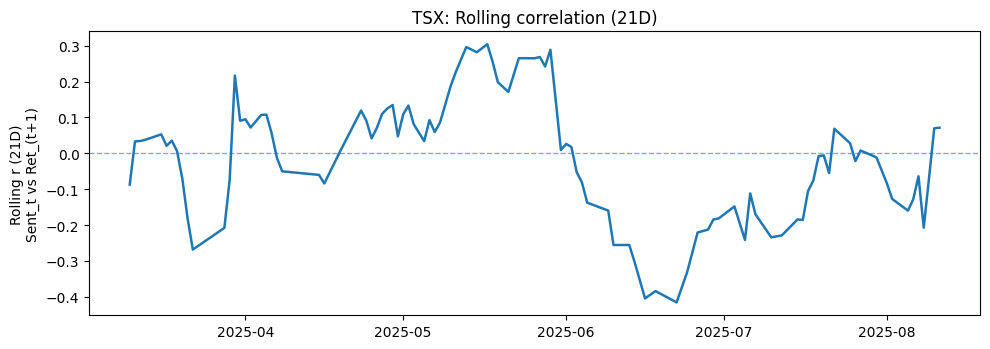

  → saved: figs/rolling_corr_TSX.png


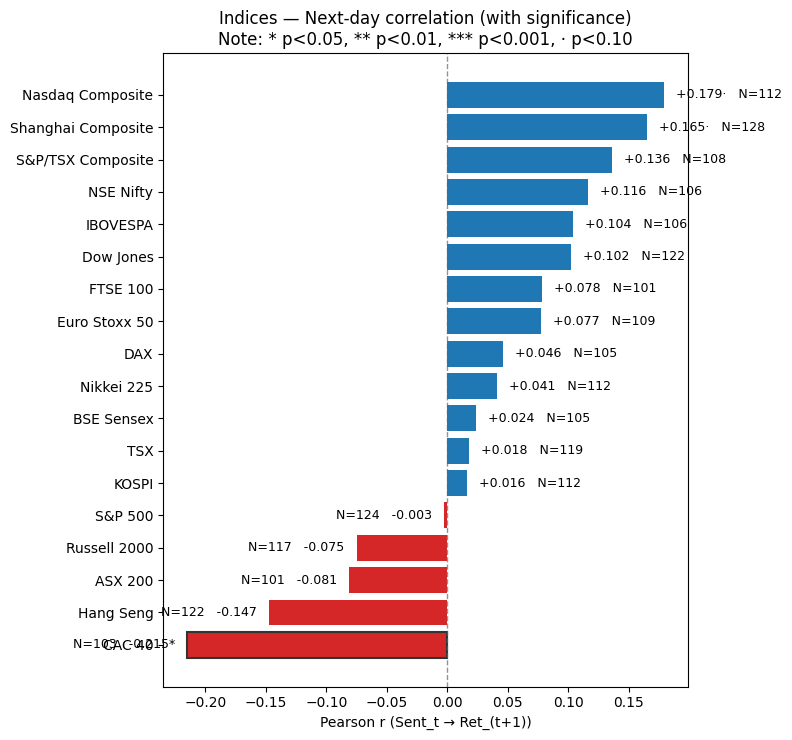

✅ Saved: figs/corr_bar_with_stars.png

🎉 Module 4 completed.


In [7]:
# ===== Module 4 (final, robust): Sentiment ↔ Market Trend & Correlation =====
# Input : financial_news_events_with_sentiment.csv  (same folder)
# Outputs:
#   - sentiment_daily_infile.csv
#   - correlation_summary.csv
#   - trend_summary.csv
#   - figs/sent_vs_market_*.png
#   - figs/rolling_corr_*.png
#   - figs/corr_bar_with_stars.png
# add sandian图

import os, re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ---------- Matplotlib (English only) ----------
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "axes.unicode_minus": True,
})

# ---------- Tunables ----------
INFILE       = "financial_news_events_with_sentiment.csv"
SMOOTH_WIN   = 3        # rolling window for sentiment smoothing (days)
ROLL_WIN     = 21       # rolling window for correlation stability (days)
MIN_N        = 10       # minimum sample size to compute stats
DEFAULT_CONF = 0.6      # default weight if confidence column missing
TOP_K_PLOTS  = 6        # plot the top-K indices by sample count
SAVE_DIR     = "figs"
os.makedirs(SAVE_DIR, exist_ok=True)

def _safe(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_.-]+", "_", str(s))

def _star(p):
    if pd.isna(p): return ""
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "·" if p < 0.10 else ""

# ---------- 1) Load & daily aggregation ----------
if not os.path.exists(INFILE):
    raise FileNotFoundError(f"Cannot find input file: {INFILE}")

df = pd.read_csv(INFILE)
print("✅ Loaded columns:", list(df.columns))

# time
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.normalize()
df = df.dropna(subset=["date"]).copy()

# index column
if "market_index" not in df.columns:
    df["market_index"] = "ALL"

# choose sentiment source: Ensemble → LLM → SLM
if "predicted_sentiment_ens" in df.columns:
    sent_col, conf_col = "predicted_sentiment_ens", "conf_ens"
elif "predicted_sentiment_llm" in df.columns:
    sent_col, conf_col = "predicted_sentiment_llm", "conf_llm"
else:
    sent_col, conf_col = "predicted_sentiment_slm", "conf_slm"

# sentiment → numeric; weight by impact level × confidence
SENT_VAL = {"Negative": -1.0, "Neutral": 0.0, "Positive": 1.0}
IMPACT_W = {"High": 1.0, "Medium": 0.6, "Low": 0.3}

df["label"] = df[sent_col].astype(str).str.title()
df["val"]   = df["label"].map(SENT_VAL).fillna(0.0)
df["w"]     = df.get("impact_level", "Medium").map(IMPACT_W).fillna(0.6)
df["conf"]  = pd.to_numeric(df.get(conf_col, DEFAULT_CONF), errors="coerce").fillna(DEFAULT_CONF).clip(0,1)
df["score"] = df["val"] * df["w"] * df["conf"]

# market return (percent → decimal if needed)
df["ret"] = pd.to_numeric(df["index_change_percent"], errors="coerce")
if df["ret"].abs().max() > 1.0:
    df["ret"] = df["ret"] / 100.0

# daily aggregation: index × date
daily = (
    df.groupby(["market_index","date"])
      .agg(sent_index=("score","mean"),
           sent_n=("score","size"),
           mkt_ret=("ret","mean"))
      .reset_index()
      .sort_values(["market_index","date"])
)

# smoothing, next-day return, cumulative index (=100)
daily["sent_smooth"] = daily.groupby("market_index")["sent_index"]\
                            .transform(lambda s: s.rolling(SMOOTH_WIN, min_periods=1).mean())
daily["mkt_ret_fwd"] = daily.groupby("market_index")["mkt_ret"].shift(-1)
daily["cum_index"]   = daily.groupby("market_index")["mkt_ret"]\
                            .transform(lambda r: (1.0 + r.fillna(0.0)).cumprod() * 100.0)

# z-scores (optional, for same-axis plotting if needed)
for col in ["sent_smooth","cum_index"]:
    daily[col+"_z"] = daily.groupby("market_index")[col].transform(
        lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1.0)
    )

daily.to_csv("sentiment_daily_infile.csv", index=False, encoding="utf-8-sig")
print(f"✅ Saved: sentiment_daily_infile.csv  (rows={len(daily)})")

# ---------- 2) Correlation summary (same-day & next-day) ----------
rows = []
for idx, g in daily.groupby("market_index"):
    g0 = g.dropna(subset=["sent_smooth","mkt_ret"])      # same-day
    g1 = g.dropna(subset=["sent_smooth","mkt_ret_fwd"])  # t→t+1

    if len(g0) >= MIN_N:
        r0, p0 = pearsonr(g0["sent_smooth"], g0["mkt_ret"])
        s0, q0 = spearmanr(g0["sent_smooth"], g0["mkt_ret"])
    else:
        r0=p0=s0=q0=np.nan

    if len(g1) >= MIN_N:
        r1, p1 = pearsonr(g1["sent_smooth"], g1["mkt_ret_fwd"])
        s1, q1 = spearmanr(g1["sent_smooth"], g1["mkt_ret_fwd"])
    else:
        r1=p1=s1=q1=np.nan

    rows.append({
        "Index": idx,
        "N (t→t+1)": len(g1), "Pearson (t→t+1)": r1, "p (t→t+1)": p1,
        "Spearman (t→t+1)": s1, "p_s (t→t+1)": q1,
        "N (t→t)"  : len(g0), "Pearson (t→t)"  : r0, "p (t→t)"  : p0,
        "Spearman (t→t)"     : s0, "p_s (t→t)" : q0,
    })

corr_df = pd.DataFrame(rows).sort_values("Pearson (t→t+1)", ascending=False)
for c in ["Pearson (t→t+1)","p (t→t+1)","Spearman (t→t+1)","p_s (t→t+1)",
          "Pearson (t→t)","p (t→t)","Spearman (t→t)","p_s (t→t)"]:
    corr_df[c] = corr_df[c].round(3)

corr_df["Pearson± (t→t+1)"]  = corr_df["Pearson (t→t+1)"].map(lambda x: f"{x:+.3f}") + corr_df["p (t→t+1)"].map(_star)
corr_df["Spearman± (t→t+1)"] = corr_df["Spearman (t→t+1)"].map(lambda x: f"{x:+.3f}") + corr_df["p_s (t→t+1)"].map(_star)

corr_df.to_csv("correlation_summary.csv", index=False, encoding="utf-8-sig")
print("✅ Saved: correlation_summary.csv")

# ---------- 3) Rolling (21D) correlation stability ----------
trend_rows = []
for idx, g in daily.groupby("market_index"):
    gg = g.dropna(subset=["sent_smooth","mkt_ret_fwd"]).copy()
    if len(gg) >= MIN_N:
        r_all, p_all = pearsonr(gg["sent_smooth"], gg["mkt_ret_fwd"])
        gg["r_roll"] = gg["sent_smooth"].rolling(ROLL_WIN, min_periods=ROLL_WIN)\
                         .corr(gg["mkt_ret_fwd"])
        trend_rows.append({
            "Index": idx,
            "N_total": len(gg),
            "Pearson_all": round(r_all, 3),
            "p_all": float(f"{p_all:.3g}"),
            "RollWin": ROLL_WIN,
            "r_roll_mean": round(float(np.nanmean(gg["r_roll"])), 3) if gg["r_roll"].notna().any() else np.nan,
            "r_roll_median": round(float(np.nanmedian(gg["r_roll"])), 3) if gg["r_roll"].notna().any() else np.nan,
            "r_roll_pos_share": round(float(np.nanmean((gg["r_roll"]>0).astype(float))), 3) if gg["r_roll"].notna().any() else np.nan
        })
    else:
        trend_rows.append({
            "Index": idx, "N_total": len(gg), "Pearson_all": np.nan, "p_all": np.nan,
            "RollWin": ROLL_WIN, "r_roll_mean": np.nan, "r_roll_median": np.nan, "r_roll_pos_share": np.nan
        })

trend_df = pd.DataFrame(trend_rows).sort_values("Pearson_all", ascending=False)
trend_df.to_csv("trend_summary.csv", index=False, encoding="utf-8-sig")
print("✅ Saved: trend_summary.csv")

# ---------- 4) Plot: dual-axis lines, rolling correlation, annotated bar ----------
rank = daily.groupby("market_index")["date"].count().sort_values(ascending=False)
targets = rank.index.tolist()[:max(1, TOP_K_PLOTS)]
print("📌 Will plot for indices:", targets)

def plot_dual(idx_name, g):
    g = g.sort_values("date").copy()
    gg = g.dropna(subset=["sent_smooth","mkt_ret_fwd"])
    title = idx_name
    if len(gg) >= MIN_N:
        r, p = pearsonr(gg["sent_smooth"], gg["mkt_ret_fwd"])
        title = f"{idx_name}: Sentiment vs Market | Pearson(t→t+1)={r:+.3f}, p={p:.3g}, n={len(gg)}"

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(g["date"], g["sent_smooth"], lw=2, label=f"Sentiment ({SMOOTH_WIN}D)")
    ax1.axhline(0, ls="--", lw=1, alpha=0.6)
    ax1.set_ylabel("Sentiment (weighted)")

    ax2 = ax1.twinx()
    ax2.plot(g["date"], g["cum_index"], lw=1.6, alpha=0.9, label="Cumulative (=100)")
    ax2.set_ylabel("Cumulative")

    ax1.set_title(title)
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1+l2, lab1+lab2, loc="upper left")
    plt.tight_layout()
    fpath = os.path.join(SAVE_DIR, f"sent_vs_market_{_safe(idx_name)}.png")
    plt.savefig(fpath, dpi=180, bbox_inches="tight")
    plt.show()
    print("  → saved:", fpath)

def plot_rollcorr(idx_name, g):
    gg = g.dropna(subset=["sent_smooth","mkt_ret_fwd"]).copy()
    if len(gg) < ROLL_WIN:
        return
    gg["r_roll"] = gg["sent_smooth"].rolling(ROLL_WIN, min_periods=ROLL_WIN).corr(gg["mkt_ret_fwd"])
    if gg["r_roll"].dropna().empty:
        return
    fig, ax = plt.subplots(figsize=(10,3.6))
    ax.plot(gg["date"], gg["r_roll"], lw=1.8)
    ax.axhline(0, ls="--", lw=1, alpha=0.6)
    ax.set_ylabel(f"Rolling r ({ROLL_WIN}D)\nSent_t vs Ret_(t+1)")
    ax.set_title(f"{idx_name}: Rolling correlation ({ROLL_WIN}D)")
    plt.tight_layout()
    fpath = os.path.join(SAVE_DIR, f"rolling_corr_{_safe(idx_name)}.png")
    plt.savefig(fpath, dpi=180, bbox_inches="tight")
    plt.show()
    print("  → saved:", fpath)

for idx_name, g in daily.groupby("market_index"):
    if idx_name not in targets: 
        continue
    plot_dual(idx_name, g)
    plot_rollcorr(idx_name, g)

# Annotated bar chart (Pearson next-day, with stars & N)
NOTE = "Note: * p<0.05, ** p<0.01, *** p<0.001, · p<0.10"
need_cols = ["Index","N (t→t+1)","Pearson (t→t+1)","p (t→t+1)"]
d = corr_df[need_cols].dropna(subset=["Pearson (t→t+1)"]).copy()
d = d.sort_values("Pearson (t→t+1)", ascending=True)
d["star"] = d["p (t→t+1)"].map(_star)

pos_color = "#1f77b4"
neg_color = "#d62728"
colors = [pos_color if r >= 0 else neg_color for r in d["Pearson (t→t+1)"]]

fig_h = max(3, 0.35*len(d) + 1.2)
fig, ax = plt.subplots(figsize=(8, fig_h))
bars = ax.barh(d["Index"], d["Pearson (t→t+1)"], color=colors)
ax.axvline(0, ls="--", lw=1, color="#666", alpha=0.7)
ax.set_xlabel("Pearson r (Sent_t → Ret_(t+1))")
ax.set_title("Indices — Next-day correlation (with significance)\n" + NOTE)

for rect, p in zip(bars, d["p (t→t+1)"].values):
    if pd.notna(p) and p < 0.05:
        rect.set_edgecolor("#333")
        rect.set_linewidth(1.5)

for yi, (rv, st, n_sample) in enumerate(zip(d["Pearson (t→t+1)"].values,
                                            d["star"].values,
                                            d["N (t→t+1)"].astype(int).values)):
    txt = f"{rv:+.3f}{st}   N={n_sample}"
    off = 0.01
    if rv >= 0:
        ax.text(rv + off, yi, txt, ha="left", va="center", fontsize=9)
    else:
        ax.text(rv - off, yi, f"N={n_sample}   {rv:+.3f}{st}", ha="right", va="center", fontsize=9)

plt.tight_layout()
out_bar = os.path.join(SAVE_DIR, "corr_bar_with_stars.png")
plt.savefig(out_bar, dpi=180, bbox_inches="tight")
plt.show()
print("✅ Saved:", out_bar)

print("\n🎉 Module 4 completed.")

In [8]:
# === Module 5 (fixed): Template-based English Daily Brief ===
import os, pandas as pd, numpy as np
from datetime import datetime

PATH_CORR, PATH_DAILY = "correlation_summary.csv", "sentiment_daily_infile.csv"
OUT_DIR = "ai_briefs"; os.makedirs(OUT_DIR, exist_ok=True)

def _star(p):
    if pd.isna(p): return ""
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "·" if p < 0.10 else ""

def generate_daily_brief():
    corr  = pd.read_csv(PATH_CORR)
    daily = pd.read_csv(PATH_DAILY)

    # ✅ 关键修复：把所有日期统一为 tz-naive（去掉时区），避免 tz-aware vs tz-naive 比较报错
    daily["date"] = pd.to_datetime(daily["date"], errors="coerce", utc=True).dt.tz_localize(None)

    # 最新一天（naive 时间戳）
    as_of_ts   = daily["date"].max()
    as_of_date = as_of_ts.date()

    # 显著性（p<0.10）的正/负相关
    pos = corr[(corr["p (t→t+1)"] < 0.10) & (corr["Pearson (t→t+1)"] > 0)]\
            .sort_values("Pearson (t→t+1)", ascending=False).head(3)
    neg = corr[(corr["p (t→t+1)"] < 0.10) & (corr["Pearson (t→t+1)"] < 0)]\
            .sort_values("Pearson (t→t+1)").head(3)

    # 当日情绪 Top3
    latest = (daily.sort_values("date")
                    .groupby("market_index").tail(1)
                    .sort_values("sent_index", ascending=False).head(3))

    # 近 3 日动量（同为 tz-naive 比较）
    lb = daily[daily["date"] >= (as_of_ts - pd.Timedelta(days=3))]
    movers = (lb.groupby("market_index")["sent_index"]
                .agg(["first","last"])
                .assign(delta=lambda x: x["last"]-x["first"])
                .sort_values("delta", ascending=False).head(3))

    def _fmt_rows(df):
        if df.empty: return "none"
        return "; ".join(f"{r.Index} r={r['Pearson (t→t+1)']:+.3f}{_star(r['p (t→t+1)'])}"
                         for _, r in df.iterrows())

    lines = []
    lines.append(f"As of {as_of_date}, the news-sentiment index shows mixed conditions across major markets.")
    lines.append(f"Statistically significant next-day correlations include: "
                 f"positive — {_fmt_rows(pos)}; negative — {_fmt_rows(neg)}.")
    if not latest.empty:
        lines.append("Today’s highest sentiment levels: " + "; ".join(
            f"{r.market_index} {r.sent_index:+.3f}" for _, r in latest.iterrows()) + ".")
    if not movers.empty:
        lines.append("Three-day sentiment momentum (top movers): " + "; ".join(
            f"{idx} {row['delta']:+.3f}" for idx, row in movers.iterrows()) + ".")
    lines.append("Correlations are modest and do not imply causality. This brief is auto-generated from the latest metrics.")
    body = " ".join(lines)

    out = os.path.join(OUT_DIR, f"ai_brief_{as_of_date}.txt")
    with open(out, "w", encoding="utf-8") as f:
        f.write(body)
    print(f"✅ saved: {out}\n\n{body}")

generate_daily_brief()

✅ saved: ai_briefs/ai_brief_2025-08-14.txt

As of 2025-08-14, the news-sentiment index shows mixed conditions across major markets. Statistically significant next-day correlations include: positive — Nasdaq Composite r=+0.179·; Shanghai Composite r=+0.165·; negative — CAC 40 r=-0.215*. Today’s highest sentiment levels: Nasdaq Composite +0.407; S&P/TSX Composite +0.206; Shanghai Composite +0.000. Three-day sentiment momentum (top movers): IBOVESPA +0.409; S&P 500 +0.283; Shanghai Composite +0.274. Correlations are modest and do not imply causality. This brief is auto-generated from the latest metrics.
